In [1]:
# Import required modules to do the task
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree
import seaborn as sns

In [111]:
# Function which does pre-processing on the data
def pre_process_data(data):

    # Create Pandas Dataframe
    df = pd.DataFrame(data)

    # Replace tabs and ? with NaN 
    df.replace('\t?', np.nan, inplace=True)
    df.replace('?', np.nan, inplace=True)

    # Renaming class column to "diagnosis" since class is a reserved keyword 
    df = df.rename({'class': 'diagnosis'}, axis=1)

    # Assign values of 0 and 1 to binary attributes
    df['rbc'].replace({'normal': 0, 'abnormal': 1}, inplace=True)
    df['pc'].replace({'normal': 0, 'abnormal': 1}, inplace=True)
    df['pcc'].replace({'notpresent': 0, 'present': 1}, inplace=True)
    df['ba'].replace({'notpresent': 0, 'present': 1}, inplace=True)
    df['htn'].replace({'no': 0, 'yes': 1}, inplace=True)
    df['dm'].replace({'no': 0, '\tno':0, '\tyes':1, ' yes':1, 'yes': 1}, inplace=True)
    df['cad'].replace({'\tno':0, 'no': 0, 'yes': 1}, inplace=True)
    df['appet'].replace({'poor': 0, 'good': 1}, inplace=True)
    df['pe'].replace({'no': 0, 'yes': 1}, inplace=True)
    df['ane'].replace({'no': 0, 'yes': 1}, inplace=True)
    df['diagnosis'].replace({'notckd': 0, 'ckd': 1}, inplace=True)

    # Get the columns as list of features
    features = list(df.columns)

    # Convert features to float values
    for feature in features:
        df[feature] = df[feature].astype(float)

    # Separate the features which are inherently integer and float types
    int_list = ['bp', 'al', 'pc', 'bu', 'pcv', 'wbcc', 'dm', 'appet', 'pe', 'pcc', 'ba', 'bgr', 'age', 'su', 'rbc', 'sod', 'cad', 'ane', 'diagnosis']
    float_list = ['sc', 'hemo', 'rbcc', 'htn', 'sg', 'pot']

    # Fill missing values in dataset with the mean values
    for val in int_list:
        df[val].fillna(round(df[val].mean()), inplace=True)

    for val in float_list:
        df[val].fillna((df[val].mean()), inplace=True)

    # Get correlation between data columns (part of data pre-processing)
    cor = df.corr()
    print("This is the the HeatMap showing correlation of attributes: ")

    # Plot Correlation HeatMap
    plot_size = plt.subplots(figsize=(20,10))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    #print(cor)

    # Our target variable is Diagnosis
    cor_target = abs(cor["diagnosis"])
    
    # The relevant features are ones which have correlation>0.5 with final class value
    relevant_features = cor_target[cor_target>0.5]

    # Put the most relevant features into a list
    extracted_features = list(relevant_features.index)

    # Intra attribute correlation analysis
    extracted_features_df = df[extracted_features]

    cor2 = extracted_features_df.corr()

    extracted_attr_list = list(extracted_features)
    attr_to_eliminate = set()

    # Set the intra attribute threshold value
    intra_attribute_thresh = 0.8

    for i in range(0, int((len(extracted_features)+1)/2)):
        cor2_attr = abs(cor2[extracted_attr_list[i]])
        # Attributes with more than 80% correlation should be said as matching
        matching_attr_with_cor = cor2_attr[cor2_attr>intra_attribute_thresh]       
        matching_attr = list(matching_attr_with_cor.index)
        
        # Extract the target corr of all the matching attributes
        target_corr = relevant_features[matching_attr]

        if len(matching_attr) > 1:
            # Eliminate the minimum attribute
            attr_to_eliminate.add(target_corr.idxmin())

    extracted_features_df = extracted_features_df.drop(attr_to_eliminate, axis=1)
    extracted_features_df = extracted_features_df.drop('diagnosis', axis=1)
    y = df['diagnosis']

    return extracted_features_df, y

In [68]:
# Train the classifier model
def train_classifier(df, y):

    # Split the dataset for training an testing
    x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.33)

    # Train the classifier
    dt = DecisionTreeClassifier(random_state = 0)
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)

    # Print accuracy score, metrics & confusion matrix
    print("score :",dt.score(x_test,y_test))
    print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return dt

In [75]:
# Plot the decision tree
def plot_decision_tree(dt):
    # This is the extracted features list
    features = ['specific gravity', 'albumin', 'hemoglobin',  \
                'red blood cell count', 'hypertension', 'diabetes']
    classes = ['notckd', 'ckd']

    # Print the tree to console in text form 
    tree_text = tree.export_text(dt, feature_names = features)
    print("This is the textual representaion of tree:")
    print(tree_text)

    # Plot the tree and save it
    print("The final decision tree looks like below:")
    fig = plt.figure(figsize=(25,30))
    my_tree = tree.plot_tree(dt, feature_names = features, class_names = classes, filled = True)
    fig.savefig("decision_tree.png")

In [96]:
# Read CSV file containing the dataset
data = pd.read_csv('kidneyChronic.csv')

This is the the HeatMap showing correlation of attributes: 


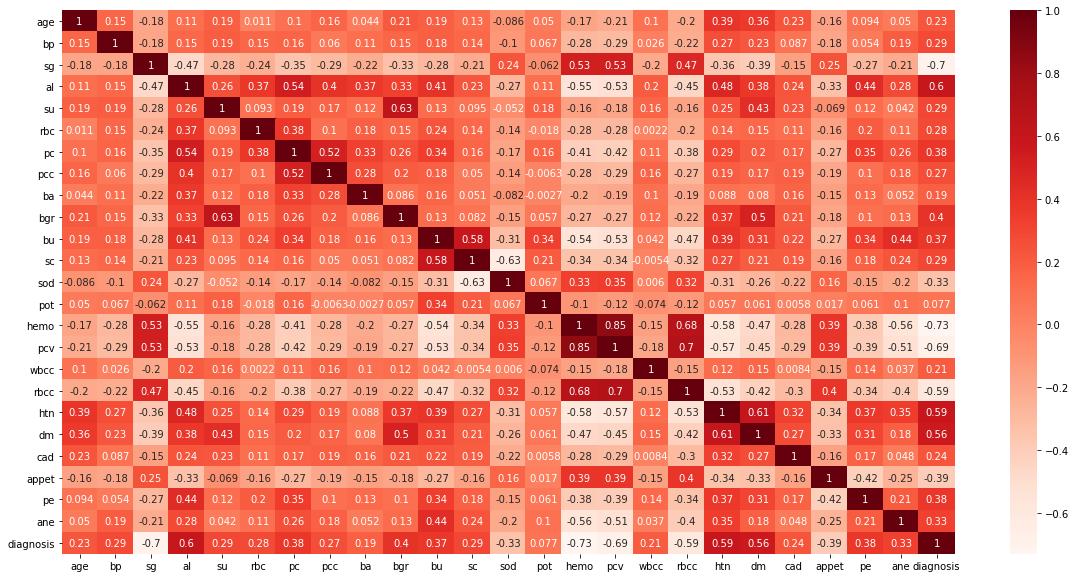

In [112]:
# Pre-process the data
pre_processed_df, y = pre_process_data(data)

In [113]:
# Train the classifier to obtain a decision tree
decision_tree = train_classifier(pre_processed_df, y)

score : 0.9848484848484849
Confusion matrix: 
 [[48  0]
 [ 2 82]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        48
         1.0       1.00      0.98      0.99        84

    accuracy                           0.98       132
   macro avg       0.98      0.99      0.98       132
weighted avg       0.99      0.98      0.98       132



This is the textual representaion of tree:
|--- hemoglobin <= 13.25
|   |--- red blood cell count <= 5.15
|   |   |--- specific gravity <= 1.02
|   |   |   |--- class: 1.0
|   |   |--- specific gravity >  1.02
|   |   |   |--- albumin <= 0.50
|   |   |   |   |--- diabetes <= 0.50
|   |   |   |   |   |--- hemoglobin <= 11.91
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- hemoglobin >  11.91
|   |   |   |   |   |   |--- specific gravity <= 1.02
|   |   |   |   |   |   |   |--- hemoglobin <= 12.61
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- hemoglobin >  12.61
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- specific gravity >  1.02
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- diabetes >  0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- albumin >  0.50
|   |   |   |   |--- class: 1.0
|   |--- red blood cell count >  5.15
|   |   |--- hemoglobin <= 12.26
|   |   |   |--- class: 1

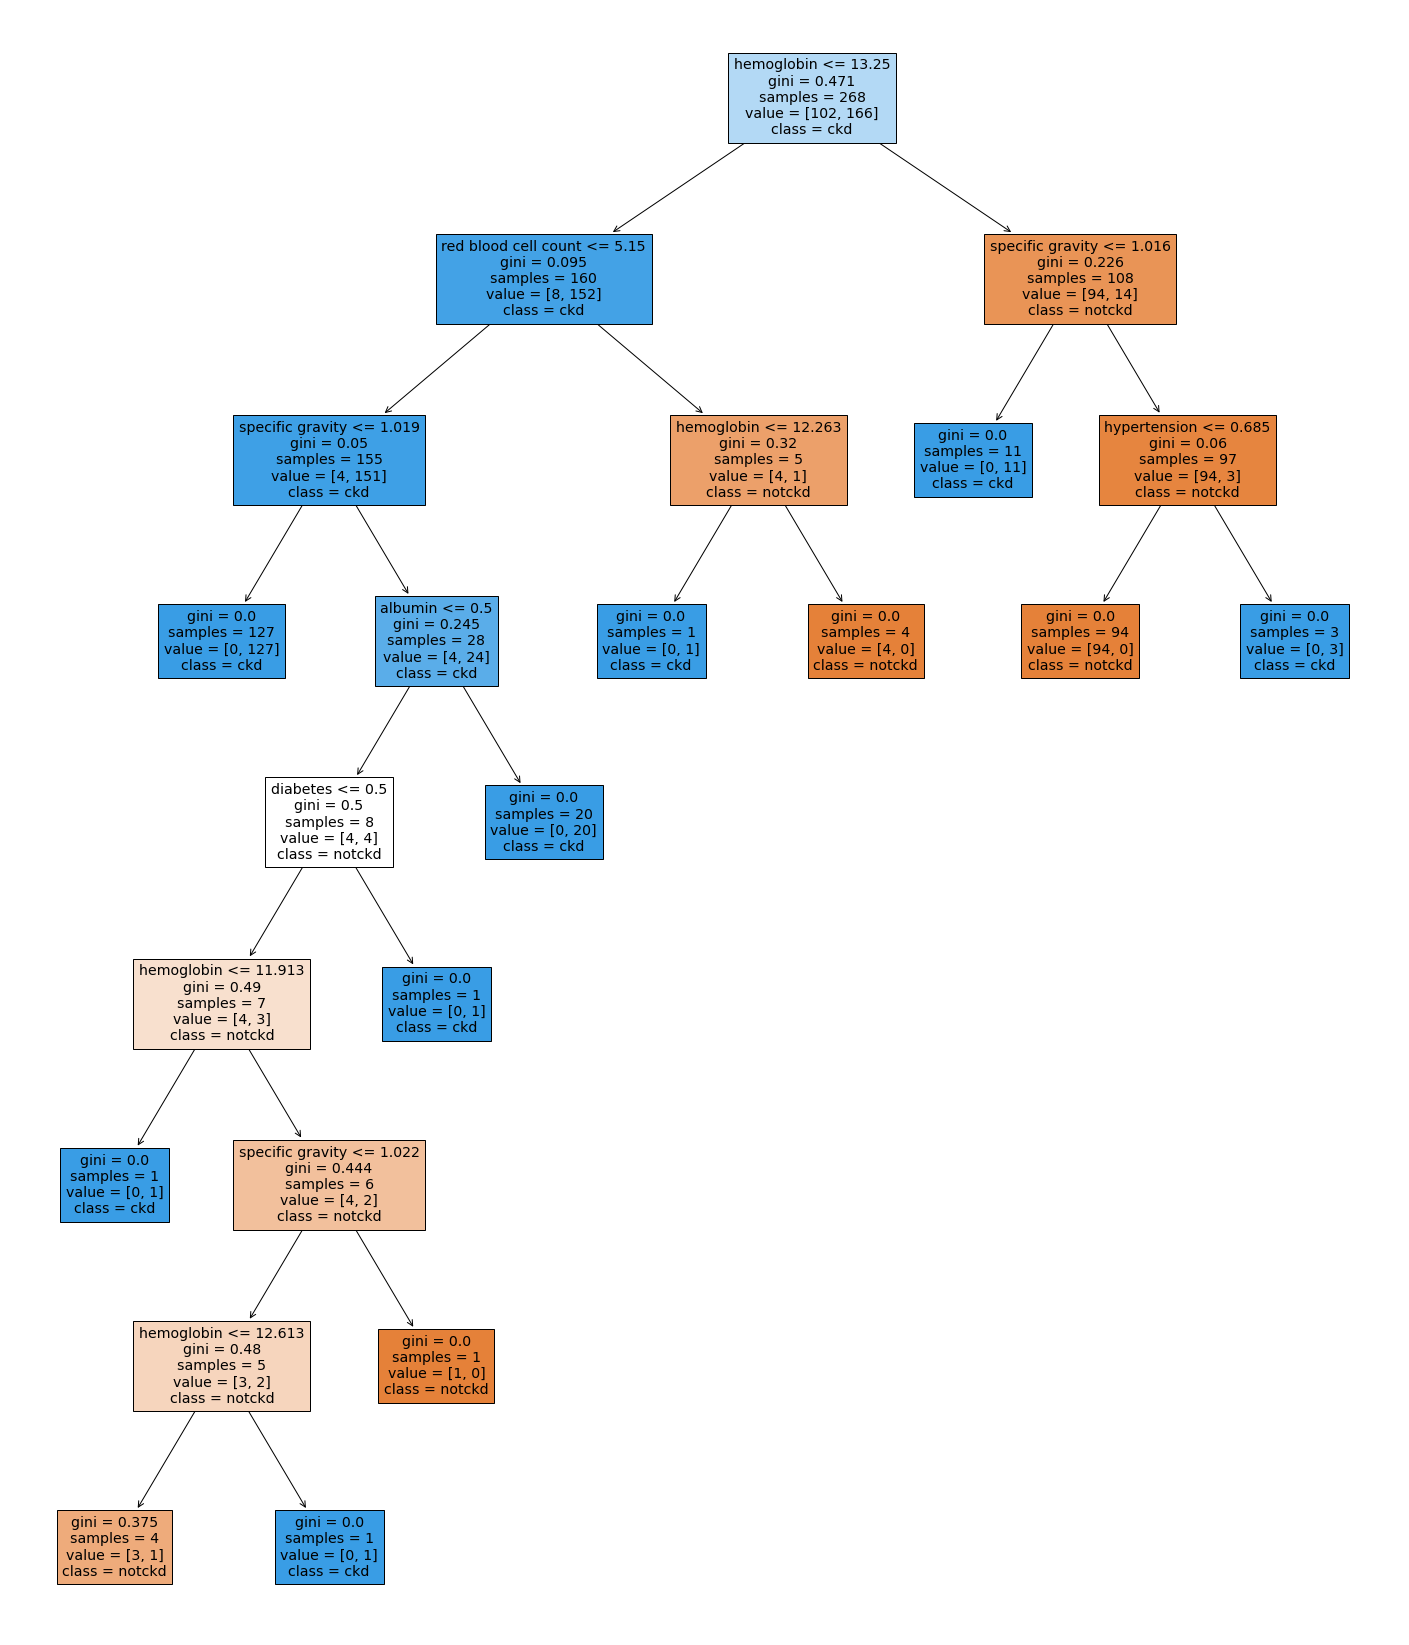

In [114]:
# Plot the decision tree obtained in a textual as well as tree form
plot_decision_tree(decision_tree)